# Link Prediction

In this notebook, we will handle the task of link prediction on the Discogs collaboration network. We will use the processed data from the pipeline in final_data_processing.ipynb. 

More specifically, we will be using:
- discogs_edges.parquet: with source, target, and release year
- discogs_artists.parquet: with a list of all our Discogs artist, which will be our nodes

Using a time factor, we want to predict future collaborations. That is the idea of our link prediction. 

## Imports and Loading Data

In [3]:
# Note: Imports

import pandas as pd
import networkx as nx
import numpy as np

artists = pd.read_parquet('../data/final_data_processed/discogs_artists.parquet')
edges = pd.read_parquet('../data/final_data_processed/discogs_edges.parquet') # Note: These will be our nodes

edges.shape, artists.shape

((5673764, 3), (1045947, 1))

## Sorting Data and splitting

Here, each row in the edges df corresponds to a collaboration with source_id, target_id, release year.

What we will do is use release_year to perform a train/test split.

In [18]:
# Note: First we will sort the edges chronologically
edges_sorted = edges.sort_values(by='release_year')
edges_sorted[:100]


,source_id,target_id,release_year
684582,732692,149701,1897
5041494,1103193,847630,1897
1917426,327547,847635,1897
1936777,327547,847635,1897
3523093,1402460,3140943,1897
...,...,...,...
5389836,15578739,6141395,1903
5389837,15578739,15578742,1903
5595074,1804446,5158950,1903
5389838,6141395,15578742,1903


### Era-based Split

Here is something we noticed, the data starts from 1897, if we do just one single split on the data, then it does not make any sense of whatever prediction we will get, because music has seen such a change in eras, and also artists are not even the same in these eras. 

What we are going to do to tackle this is we have our edges sorted chronologically, so we will divide our entire Discogs dataset into different musical eras. This way, we preserve the genre ecosystems, the change in artists, the technology and recording environments, and actually get predictions that are better explainable.

It will also help us analyze and understand how collaboration changed over years, which will make our entire analysis even more insightful.

This it the division we will follow:
- Era 1: Early Recording (1897 - 1945)
- Era 2: Post-WWII / Early Rock (1946 - 1965)
- Era 3: Classic Rock / Studio Revolution (1966 - 1982)
- Era 4: MTV and Digital Sampling (1983 - 1999)
- Era 5: The Internet / Streaming Era (2000 - Present)

For each era, we will:
- Filter the edges inside the year range
- Recompute the artists set (all unqiue IDs appearing in that era)
- Store each era as its own DataFram for later train/test splitting

This way, we can run independent link prediction models inside each era.

In [20]:
# Note: Now, based on earlier divisions, let us create our 5 data splits

# Note: For each era, we will first extract the edges from edges_sorted for the relevant release years, following
# which we will build the era's artists df using the unique() source_id and target_ids of those edges

# Note: Era 1
era1_edges = edges_sorted[(edges_sorted['release_year'] >= 1897) & (edges_sorted['release_year'] <= 1945)]

era1_artists = pd.DataFrame({'discogs_artist_id': pd.unique(pd.concat([era1_edges.source_id, era1_edges.target_id]))})
print('Era 1')
print(len(era1_edges), len(era1_artists))

# Note: Era 2
era2_edges = edges_sorted[(edges_sorted['release_year'] >= 1946) & (edges_sorted['release_year'] <= 1965)]

era2_artists = pd.DataFrame({'discogs_artist_id': pd.unique(pd.concat([era2_edges.source_id, era2_edges.target_id]))})
print('Era 2')
print(len(era2_edges), len(era2_artists))

# Note: Era 3
era3_edges = edges_sorted[(edges_sorted['release_year'] >= 1966) & (edges_sorted['release_year'] <= 1982)]

era3_artists = pd.DataFrame({'discogs_artist_id': pd.unique(pd.concat([era3_edges.source_id, era3_edges.target_id]))})
print('Era 3')
print(len(era3_edges), len(era3_artists))

# Note: Era 4
era4_edges = edges_sorted[(edges_sorted['release_year'] >= 1983) & (edges_sorted['release_year'] <= 2000)]

era4_artists = pd.DataFrame({'discogs_artist_id': pd.unique(pd.concat([era4_edges.source_id, era4_edges.target_id]))})
print('Era 4')
print(len(era4_edges), len(era4_artists))

# Note: Era 5
era5_edges = edges_sorted[(edges_sorted['release_year'] >= 2000) & (edges_sorted['release_year'] <= 2025)]

era5_artists = pd.DataFrame({'discogs_artist_id': pd.unique(pd.concat([era5_edges.source_id, era5_edges.target_id]))})
print('Era 5')
print(len(era5_edges), len(era5_artists))


Era 1
75692 20498
Era 2
649017 73293
Era 3
1153888 152055
Era 4
1542239 240600
Era 5
2338167 620672


## Train/Test Split for Each Era

In this bit, we will get the train/test splits for each musical era, and because we are doing a time based chronological split, we will follow a temporal link prediction methods (meaning we cannot use future collaborations to predict past ones), which will be as follows:

1. We will sort all the edges by the release_year
2. We will select a cutoff year for each era
3. All collaborations before or equal to the cut off year go into the train graph, and the latter into the test graph
4. Only the test edges where both nodes already exist in the train graph are kept

In [21]:
# Note: We will be using a function to get the cutoff year
def compute_cutoff(df, pct=0.8):
    years = df['release_year'].sort_values().unique()
    return years[int(len(years) * pct)]

# Note: Now just run it on the diff era edges we have
cut1 = compute_cutoff(era1_edges)
cut2 = compute_cutoff(era2_edges)
cut3 = compute_cutoff(era3_edges)
cut4 = compute_cutoff(era4_edges)
cut5 = compute_cutoff(era5_edges)

cut1, cut2, cut3, cut4, cut5

(1936, 1962, 1979, 1997, 2020)

In [22]:
# Note: Now that we have our 3 cuts, we will implement that to get our train, test data for all 5 eras:

# Era 1 train/test split
era1_train = era1_edges[era1_edges['release_year'] <= cut1]
era1_test  = era1_edges[era1_edges['release_year'] > cut1]
print(f'Era 1: {len(era1_train), len(era1_test)}')

# Era 2 train/test split

era2_train = era2_edges[era2_edges['release_year'] <= cut2]
era2_test  = era2_edges[era2_edges['release_year'] > cut2]
print(f'Era 2: {len(era2_train), len(era2_test)}')

# Era 3 train/test split

era3_train = era3_edges[era3_edges['release_year'] <= cut3]
era3_test  = era3_edges[era3_edges['release_year'] > cut3]
print(f'Era 3: {len(era3_train), len(era3_test)}')

# Era 4 train/test split

era4_train = era4_edges[era4_edges['release_year'] <= cut4]
era4_test  = era4_edges[era4_edges['release_year'] > cut4]
print(f'Era 4: {len(era4_train), len(era4_test)}')

# Era 5 train/test split

era5_train = era5_edges[era5_edges['release_year'] <= cut5]
era5_test  = era5_edges[era5_edges['release_year'] > cut5]
print(f'Era 5: {len(era5_train), len(era5_test)}')

Era 1: (52269, 23423)
Era 2: (476093, 172924)
Era 3: (930641, 223247)
Era 4: (1285587, 256652)
Era 5: (1940401, 397766)


### Ensure Valid Test Edges

There is one thing though, a test edge (u,v) is only meaningful if both the nodes are in the train graph, otherwise the model will not be able to predict it using structural information, aka just looking at the graph data, of the train data. Therefore, we will filter the test sets to only include edges wehre: source_id is in train_nodes, target_id is in test_nodes.

A more explanable way to put this is, if we think about a cut off year, then the model only knows the artists up until that point, then if new artists come into play after that year then the model could not possible predict the artist's future collaborations because they never existed in the graph until after the test period began. Same idea for artists whose careers end.

In [24]:
# Note: We will use a function to help us filter as we discribed earlier
def filter_artist_only_after_test(train_edges, test_edges):
    train_nodes = set(train_edges['source_id']).union(train_edges['target_id'])
    return test_edges[(test_edges['source_id'].isin(train_nodes)) & (test_edges['target_id'].isin(train_nodes))] 

# Note: Now we just apply this filtering to each era
era1_test = filter_artist_only_after_test(era1_train, era1_test)
era2_test = filter_artist_only_after_test(era2_train, era2_test)
era3_test = filter_artist_only_after_test(era3_train, era3_test)
era4_test = filter_artist_only_after_test(era4_train, era4_test)
era5_test = filter_artist_only_after_test(era5_train, era5_test)

# Note: Now let us just print the final lengths after all processing before moving on to making the actual graphs
print("Era 1:", len(era1_train), len(era1_test))
print("Era 2:", len(era2_train), len(era2_test))
print("Era 3:", len(era3_train), len(era3_test))
print("Era 4:", len(era4_train), len(era4_test))
print("Era 5:", len(era5_train), len(era5_test))

Era 1: 52269 8905
Era 2: 476093 123529
Era 3: 930641 165516
Era 4: 1285587 158776
Era 5: 1940401 194184


## Build Train Graph

From here on out, until we do the final prediction on each train dataset for each era, what we will do is we will create functions such that we can then run these functions on each era to get the predictions.

For the first one, we are going to be building a train graph, given teh train edges for an era, we will construct an undirected nx Graph

In [26]:
def build_train_graph(train_df):
    # Note: We will be building the training graph given the training edges of an era
    G = nx.Graph()
    for _, row in train_df.iterrows():
        G.add_edge(row['source_id'], row['target_id'])
    return G

## Sampling Negative Edges

In this helper function, we will sample negative edges (u,v) such that: u != v, u and v both exist in the train graph and there is no edge u,v in the train graph

Basically, this aligns with the link prediction with the original Liben-Nowell % Kleinberg (2007) work, where the authors implicitly treat all non-edges as negative samples when ranking node similarity. Because our graph is very large, we follow the standard scalable apporximation used in modern graph mining and randomly sample an equal-szied set of non-edges to serve as negatives.

Reference: David Liben-Nowell and Jon Kleinberg. 2003. The link prediction problem for social networks. In Proceedings of the twelfth international conference on Information and knowledge management (CIKM '03). Association for Computing Machinery, New York, NY, USA, 556–559. https://doi.org/10.1145/956863.956972

In [30]:
import random

def sample_negative_edges(G, positive_edges, seed = 42):
    # Note: Here we will sample the engative edges equal in number to the positive edges
    random.seed(seed)
    nodes = list(G.nodes())
    negatives = set()
    target_count = len(positive_edges)

    while len(negatives) < target_count:
        u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v):
            negatives.add(tuple(sorted((u, v))))
    return list(negatives)

## Compute the Scores

Now here we will get the structural scores, as mentioned in the project abstract:
- Common Neighbors
- Jaccard Similarity
- Adamic-Adar Index
- Preferential Attachment (PA)

The ideas below and the idea for link prediction are inspired by the earlier mentioned paper by Liben-Nowell and Kleinberg.

In [34]:
def compute_scores(G, edge_list):
    # Note: Here we will compute the CN, Jaccard, Adamic-Adar, PA for the edges and return a df
    # Note: Common Neighbors
    cn_scores = [len(list(nx.common_neighbors(G, u, v))) for u, v in edge_list]

    # Note: Jaccard
    jaccard_dict = {(u, v): p for u, v, p in nx.jaccard_coefficient(G, edge_list)}
    jaccard_scores = [jaccard_dict.get((u, v), 0.0) for (u, v) in edge_list]

    # Note: Adamic-Adar
    # Note: We need to basically skip when deg=1 to avoid 1/log(1) division by zero, that is the only reason for
    # this implementation as is in the stack overflow link
    aa_scores = []
    for u, v in edge_list:
        aa_sum = 0.0
        for w in nx.common_neighbors(G, u, v):
            deg = G.degree(w)
            if deg > 1: aa_sum += 1 / np.log(deg)
        aa_scores.append(aa_sum)

    # Note: Preferential Attachment
    pa_dict = {(u, v): p for u, v, p in nx.preferential_attachment(G, edge_list)}
    pa_scores = [pa_dict.get((u, v), 0.0) for (u, v) in edge_list]

    # Note: Return a DF w/ all the computed scores
    return pd.DataFrame({'u' : [u for u, v in edge_list],'v': [v for u, v in edge_list],'cn': cn_scores,'jaccard': jaccard_scores, 'aa': aa_scores, 'pa': pa_scores})
# Reference: https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.degree.html
# Reference: https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.common_neighbors.html
# Reference: https://stackoverflow.com/questions/29836964/error-python-zerodivisionerror-division-by-zero
# Reference: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.preferential_attachment.html
# Reference: David Liben-Nowell and Jon Kleinberg. 2003. The link prediction problem for social networks. In Proceedings of the twelfth international conference on Information and knowledge management (CIKM '03). Association for Computing Machinery, New York, NY, USA, 556–559. https://doi.org/10.1145/956863.956972


## Full Pipeline for each era

Now, through this function, we will run the entire link prediction pipeline for on era

Here's what this function does:
1. Build a training graph
2. Construct positive edges (test set)
3. Sample negative edges
4. Compute the scores for both
5. Put results into the data frame

In [35]:
def run_pipeline_for_era(train_df, test_df):
    # Note: Run full link prediction pipeline (training + structural scoring); this returns a DataFrame with predictions
    
    # Note: First build train graph
    G = build_train_graph(train_df)

    # Note: Then we get the positive edges
    positives = list(zip(test_df['source_id'], test_df['target_id']))

    # Note: Then we get the negative edges
    negatives = sample_negative_edges(G, positives)

    # Note: Then we get the scores for all edges
    all_edges = positives + negatives
    labels = [1]*len(positives) + [0]*len(negatives)

    scores_df = compute_scores(G, all_edges)
    scores_df['label'] = labels

    return scores_df

## Run the actual pipeline on the eras
Now that we have our pipleine ready, we will run it on all 5 eras, each result will be saved separately

Here's what we will get and how we will use that for the pipeline, just briefly explaining the entire process and what the results actually mean and how the evaluation phase will look like(since link prediction here is diff from ML based link prediction).

### What the pipeline above is doing
1. Firstly we are building the training graph for an era, here we use only the collaborations that occured up to the era's cutoff year. This gives us a graph G_train that will have the nodes which will be the artists known by that time, and the edges which will be the collaborations before the cutoff year.
2. It then helps us identify the future collaborations (positives), basically these are the artists that in the next time window (the test period), actually collaborated in reality. These are what we try to predict
3. We then sample the negative (non-edge) examples, where we randomly select the sample pairs of artists (u, v) that existed in the train graph, but did not collaborate in the train graph and are not connected in the test set either. These serve as the non-collaborations. This follows the standard method in Liben-Nowell & Kleinberg (2007). We match the number of positive examples so the dataset is balanced.
4. We then compute the 4 link-prediction scores, where for every positive and negative pair we have: Common Neighbors, Jaccard Coefficient, Adamic-Adar, Preferential Attachment. These scores tell us how strongly the graph structure suggests a link between the two artists. This step is the actual prediction part, meaning there is no training or machine learning model here but structural link prediction uses graph topology directly.
5. We then combine the scores and labels into one data frame, where for each pair, we get all the stuff in the dataframe as we can see above. This dataframe is the final output of the pipeline. We save it separately for Eras 1-5.

### What the evaluation phase will look like now
1. First step will be loading the score datafram for each era wehre each row represents a predicted vs non-predicted collaboration
2. It also computes the evaluation metrics, such as AUC, Precision, Recall, Hits, Average Precision, these metrics will tell us how well the structural scores separate real future edges from non-edges
3. Compare methods by determining which structural mechanism is strongest, like is it the triadic closure or homophily/Jaccard or PA?
4. We will visualize the findings like all the curves and score distributions and Gephi with diff features

Here's a simpler way to put everything, calculate the scores for 2 artists who don't collaborate in the train, and then look at their actual score in the test set, then compare that with the fact of whether they actually collaborate in the future or not, then compare which indicator or score actually makes more sense on future collaborations.

**Now let us actually run our above pipeline and get all the results**


In [36]:
all_results = {}

# Note: A dict will help go through each era
eras = {
    "Era1": (era1_train, era1_test),
    "Era2": (era2_train, era2_test),
    "Era3": (era3_train, era3_test),
    "Era4": (era4_train, era4_test),
    "Era5": (era5_train, era5_test)
}
for era, (train_df, test_df) in eras.items():
    print(f'Running {era}')
    result_df = run_pipeline_for_era(train_df, test_df)
    all_results[era] = result_df

Running Era1
Running Era2
Running Era3
Running Era4
Running Era5


## Saving the results

Just so its easier to see, lets just store the results so evaluation is also easier by loading these in diff notebooks or here, either works.

In [ ]:
import os
PREDS_DIR = '../outputs/link_prediction_outputs'
os.makedirs(PREDS_DIR, exist_ok=True)

# Note: Just gonna save separately for each era
for era, df in all_results.items():
    path = os.path.join(PREDS_DIR, f'{era}_scores.parquet')
    df.to_parquet(path, index=False)
    print('Saved:', path)

Saved: ../outputs/link_prediction_outputs/Era1_scores.parquet
Saved: ../outputs/link_prediction_outputs/Era2_scores.parquet
Saved: ../outputs/link_prediction_outputs/Era3_scores.parquet
Saved: ../outputs/link_prediction_outputs/Era4_scores.parquet
Saved: ../outputs/link_prediction_outputs/Era5_scores.parquet


In [40]:
# Note: This just to look at the actual all_results.items(), to see if it actually got correct or not
for era, df in all_results.items():
    print(f"\n===== {era} =====")
    display(df)
    print(df.shape)


===== Era1 =====


,u,v,cn,jaccard,aa,pa,label
0,617133,27519,25,0.925926,11.404587,676,1
1,1115796,692199,1,0.333333,1.442695,4,1
2,2012714,2012714,1,1.000000,0.455120,1,1
3,2012714,1279447,0,0.000000,0.000000,8,1
4,2012714,1279447,0,0.000000,0.000000,8,1
...,...,...,...,...,...,...,...
17805,5747293,9701644,0,0.000000,0.000000,6,0
17806,4380135,8093947,0,0.000000,0.000000,6,0
17807,2465328,7940259,0,0.000000,0.000000,2,0
17808,1342926,4802376,0,0.000000,0.000000,4,0


(17810, 7)

===== Era2 =====


,u,v,cn,jaccard,aa,pa,label
0,1202353,212726,7,0.020290,1.337389,7282,1
1,335760,754974,8,0.027491,1.512765,9540,1
2,1202353,841357,6,0.072289,2.194820,1518,1
3,283122,754974,79,0.227011,17.201312,43460,1
4,23755,97545,10,0.116279,2.964780,2385,1
...,...,...,...,...,...,...,...
247053,2699833,7923643,0,0.000000,0.000000,1,0
247054,1784030,7826889,0,0.000000,0.000000,5,0
247055,1550561,2648723,0,0.000000,0.000000,9,0
247056,4676515,764634,0,0.000000,0.000000,1,0


(247058, 7)

===== Era3 =====


,u,v,cn,jaccard,aa,pa,label
0,479037,604396,44,0.099773,8.327855,57036,1
1,534822,845760,16,0.047619,2.561475,25792,1
2,837498,578737,41,0.124620,7.864492,28512,1
3,671327,998334,13,0.046263,2.767220,7980,1
4,95546,832989,77,0.027160,18.132655,322115,1
...,...,...,...,...,...,...,...
331027,1624263,1952900,0,0.000000,0.000000,2,0
331028,6332323,828135,0,0.000000,0.000000,4,0
331029,2661644,285561,0,0.000000,0.000000,32,0
331030,1779759,7302023,0,0.000000,0.000000,3,0


(331032, 7)

===== Era4 =====


,u,v,cn,jaccard,aa,pa,label
0,270225,397620,125,0.164042,24.015619,187680,1
1,173361,1167359,2,0.500000,0.927380,8,1
2,1671776,931253,12,0.089552,2.663263,4653,1
3,855218,836185,20,0.055556,4.149931,36381,1
4,264626,295651,0,0.000000,0.000000,108,1
...,...,...,...,...,...,...,...
317547,1023806,4215696,0,0.000000,0.000000,33,0
317548,269645,4376052,0,0.000000,0.000000,2,0
317549,287297,7520388,0,0.000000,0.000000,2,0
317550,3886729,6517021,0,0.000000,0.000000,28,0


(317552, 7)

===== Era5 =====


,u,v,cn,jaccard,aa,pa,label
0,1041969,836185,15,0.064655,2.955461,8772,1
1,1643411,874186,1,0.017241,0.238683,814,1
2,44615,892616,0,0.000000,0.000000,4,1
3,2155036,2155038,7,0.777778,4.312635,64,1
4,6490867,687339,2,0.117647,1.007347,48,1
...,...,...,...,...,...,...,...
388363,381870,4419502,0,0.000000,0.000000,4,0
388364,5459531,779803,0,0.000000,0.000000,4,0
388365,3567317,7995809,0,0.000000,0.000000,7,0
388366,3234040,526612,0,0.000000,0.000000,12,0


(388368, 7)


## Evaluation
AUC, Precision, recall, Hits@K, score distribution



===== Evaluating Era 1 =====

--- Evaluating Metric: aa ---
         u        v  cn   jaccard        aa   pa  label
0   617133    27519  25  0.925926  0.077172  676      1
1  1115796   692199   1  0.333333  0.009762    4      1
2  2012714  2012714   1  1.000000  0.003080    1      1
3  2012714  1279447   0  0.000000  0.000000    8      1
4  2012714  1279447   0  0.000000  0.000000    8      1
AUC for aa: 0.8619439961588431
Precision: 1.0
Recall: 0.00022459292532285232
Hits@1000: 0.0564


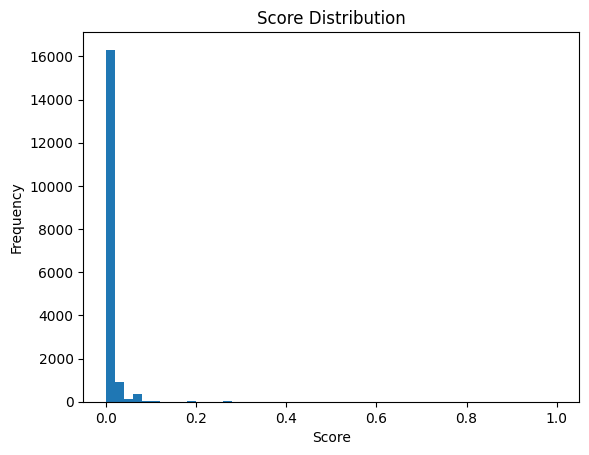


--- Evaluating Metric: cn ---
         u        v        cn   jaccard        aa   pa  label
0   617133    27519  0.090580  0.925926  0.077172  676      1
1  1115796   692199  0.003623  0.333333  0.009762    4      1
2  2012714  2012714  0.003623  1.000000  0.003080    1      1
3  2012714  1279447  0.000000  0.000000  0.000000    8      1
4  2012714  1279447  0.000000  0.000000  0.000000    8      1
AUC for cn: 0.8627797945813332
Precision: 1.0
Recall: 0.00022459292532285232
Hits@1000: 0.0561


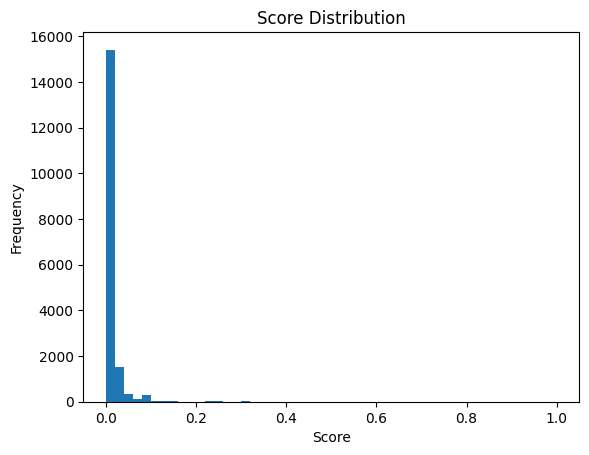


--- Evaluating Metric: jaccard ---
         u        v        cn   jaccard        aa   pa  label
0   617133    27519  0.090580  0.925926  0.077172  676      1
1  1115796   692199  0.003623  0.333333  0.009762    4      1
2  2012714  2012714  0.003623  1.000000  0.003080    1      1
3  2012714  1279447  0.000000  0.000000  0.000000    8      1
4  2012714  1279447  0.000000  0.000000  0.000000    8      1
AUC for jaccard: 0.8625030509517614
Precision: 1.0
Recall: 0.08287478944413251
Hits@1000: 0.0592


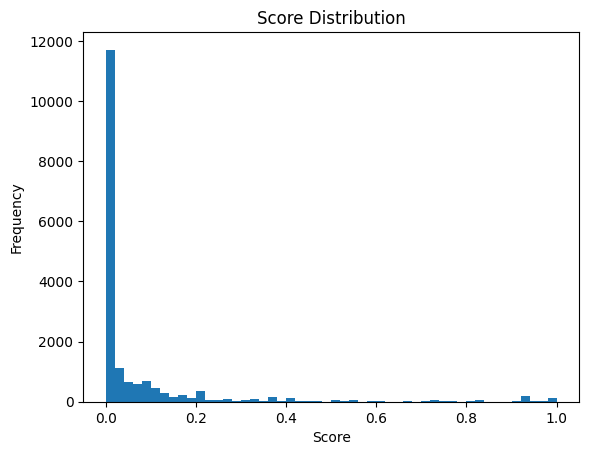


--- Evaluating Metric: pa ---
         u        v        cn   jaccard        aa        pa  label
0   617133    27519  0.090580  0.925926  0.077172  0.008734      1
1  1115796   692199  0.003623  0.333333  0.009762  0.000039      1
2  2012714  2012714  0.003623  1.000000  0.003080  0.000000      1
3  2012714  1279447  0.000000  0.000000  0.000000  0.000091      1
4  2012714  1279447  0.000000  0.000000  0.000000  0.000091      1
AUC for pa: 0.926583384852462
Precision: 1.0
Recall: 0.00022459292532285232
Hits@1000: 0.0561


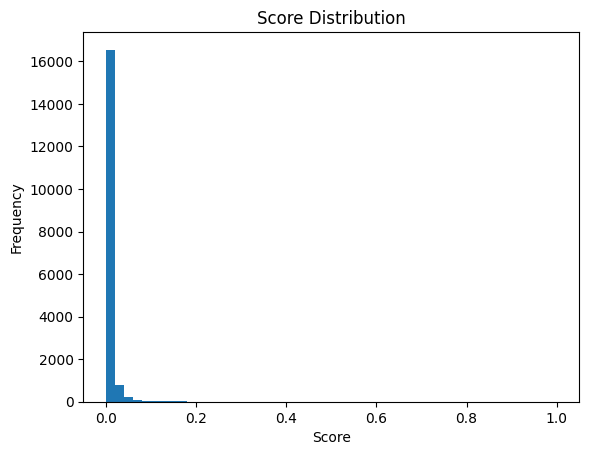


===== Evaluating Era 2 =====

--- Evaluating Metric: aa ---
         u       v  cn   jaccard        aa     pa  label
0  1202353  212726   7  0.020290  0.003010   7282      1
1   335760  754974   8  0.027491  0.003405   9540      1
2  1202353  841357   6  0.072289  0.004940   1518      1
3   283122  754974  79  0.227011  0.038718  43460      1
4    23755   97545  10  0.116279  0.006673   2385      1
AUC for aa: 0.9244323030677807
Precision: 1.0
Recall: 3.238106031782011e-05
Hits@1000: 0.0056


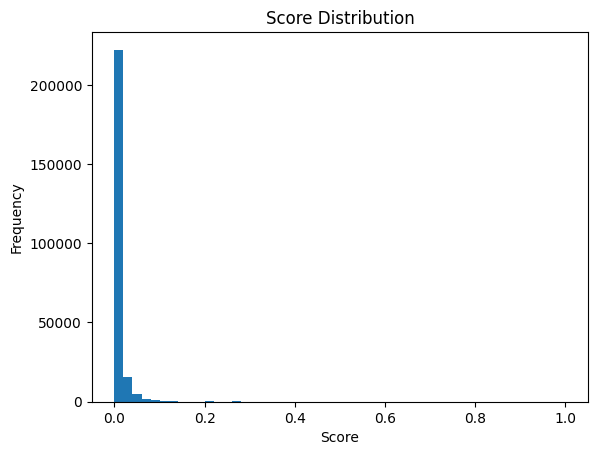


--- Evaluating Metric: cn ---
         u       v        cn   jaccard        aa     pa  label
0  1202353  212726  0.006189  0.020290  0.003010   7282      1
1   335760  754974  0.007073  0.027491  0.003405   9540      1
2  1202353  841357  0.005305  0.072289  0.004940   1518      1
3   283122  754974  0.069850  0.227011  0.038718  43460      1
4    23755   97545  0.008842  0.116279  0.006673   2385      1
AUC for cn: 0.92461334996308
Precision: 1.0
Recall: 0.0004533348444494815
Hits@1000: 0.0041


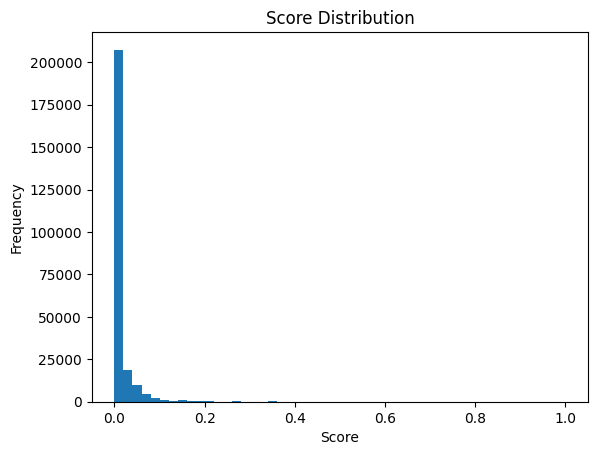


--- Evaluating Metric: jaccard ---
         u       v        cn   jaccard        aa     pa  label
0  1202353  212726  0.006189  0.020290  0.003010   7282      1
1   335760  754974  0.007073  0.027491  0.003405   9540      1
2  1202353  841357  0.005305  0.072289  0.004940   1518      1
3   283122  754974  0.069850  0.227011  0.038718  43460      1
4    23755   97545  0.008842  0.116279  0.006673   2385      1
AUC for jaccard: 0.9240981558617917
Precision: 0.9991478483170004
Recall: 0.037966793222644075
Hits@1000: 0.0041


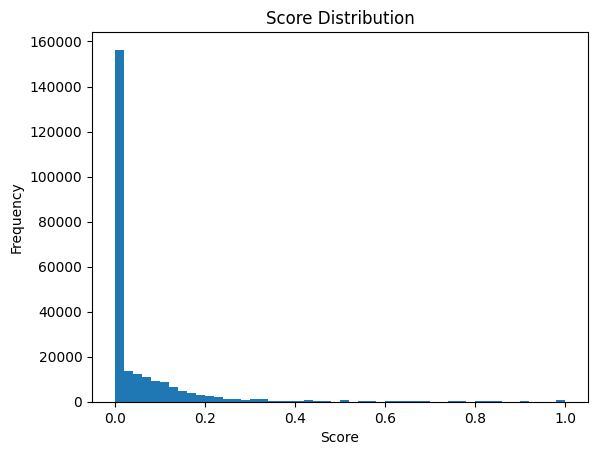


--- Evaluating Metric: pa ---
         u       v        cn   jaccard        aa        pa  label
0  1202353  212726  0.006189  0.020290  0.003010  0.003859      1
1   335760  754974  0.007073  0.027491  0.003405  0.005056      1
2  1202353  841357  0.005305  0.072289  0.004940  0.000804      1
3   283122  754974  0.069850  0.227011  0.038718  0.023034      1
4    23755   97545  0.008842  0.116279  0.006673  0.001264      1
AUC for pa: 0.9570146935305205
Precision: 1.0
Recall: 0.0022181026317706774
Hits@1000: 0.0041


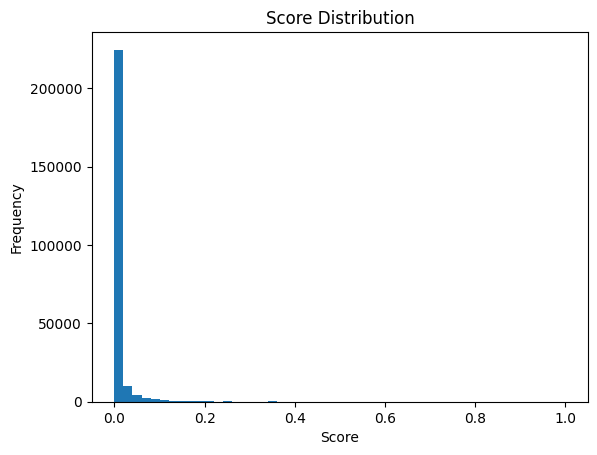


===== Evaluating Era 3 =====

--- Evaluating Metric: aa ---
        u       v  cn   jaccard        aa      pa  label
0  479037  604396  44  0.099773  0.007219   57036      1
1  534822  845760  16  0.047619  0.002220   25792      1
2  837498  578737  41  0.124620  0.006817   28512      1
3  671327  998334  13  0.046263  0.002399    7980      1
4   95546  832989  77  0.027160  0.015718  322115      1
AUC for aa: 0.9252774794351231
Precision: 1.0
Recall: 7.854225573358467e-05
Hits@1000: 0.0030


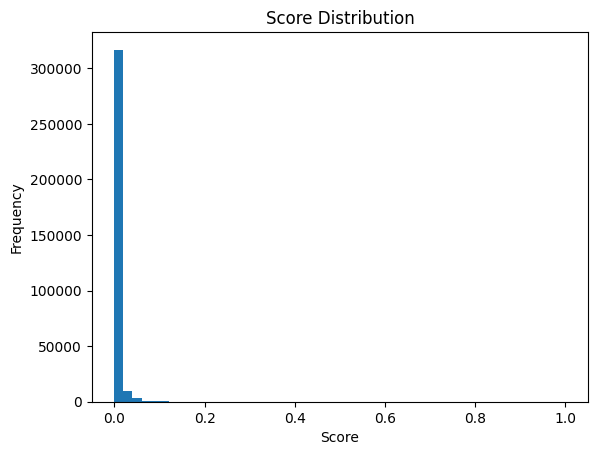


--- Evaluating Metric: cn ---
        u       v        cn   jaccard        aa      pa  label
0  479037  604396  0.015720  0.099773  0.007219   57036      1
1  534822  845760  0.005716  0.047619  0.002220   25792      1
2  837498  578737  0.014648  0.124620  0.006817   28512      1
3  671327  998334  0.004645  0.046263  0.002399    7980      1
4   95546  832989  0.027510  0.027160  0.015718  322115      1
AUC for cn: 0.9256787033201037
Precision: 1.0
Recall: 9.062567969259769e-05
Hits@1000: 0.0032


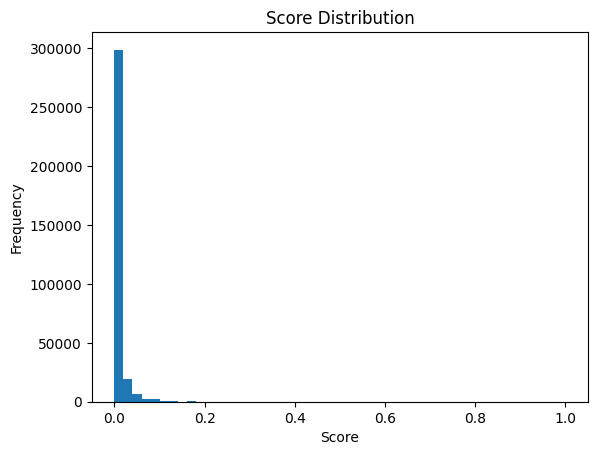


--- Evaluating Metric: jaccard ---
        u       v        cn   jaccard        aa      pa  label
0  479037  604396  0.015720  0.099773  0.007219   57036      1
1  534822  845760  0.005716  0.047619  0.002220   25792      1
2  837498  578737  0.014648  0.124620  0.006817   28512      1
3  671327  998334  0.004645  0.046263  0.002399    7980      1
4   95546  832989  0.027510  0.027160  0.015718  322115      1
AUC for jaccard: 0.9252764737607064
Precision: 0.9996531390912244
Recall: 0.03482442784987554
Hits@1000: 0.0030


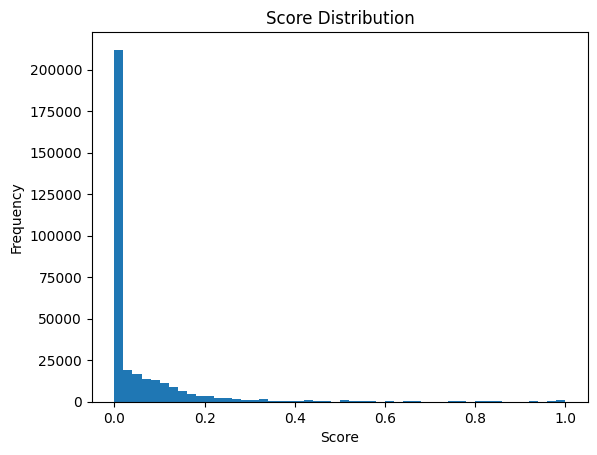


--- Evaluating Metric: pa ---
        u       v        cn   jaccard        aa        pa  label
0  479037  604396  0.015720  0.099773  0.007219  0.007270      1
1  534822  845760  0.005716  0.047619  0.002220  0.003287      1
2  837498  578737  0.014648  0.124620  0.006817  0.003634      1
3  671327  998334  0.004645  0.046263  0.002399  0.001017      1
4   95546  832989  0.027510  0.027160  0.015718  0.041057      1
AUC for pa: 0.960883132426487
Precision: 1.0
Recall: 0.0013473017714299524
Hits@1000: 0.0030


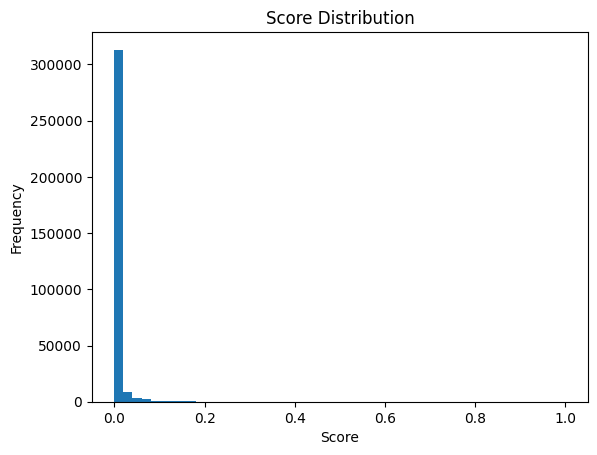


===== Evaluating Era 4 =====

--- Evaluating Metric: aa ---
         u        v   cn   jaccard        aa      pa  label
0   270225   397620  125  0.164042  0.016266  187680      1
1   173361  1167359    2  0.500000  0.000628       8      1
2  1671776   931253   12  0.089552  0.001804    4653      1
3   855218   836185   20  0.055556  0.002811   36381      1
4   264626   295651    0  0.000000  0.000000     108      1
AUC for aa: 0.886860942229431
Precision: 1.0
Recall: 4.408726759711795e-05
Hits@1000: 0.0032


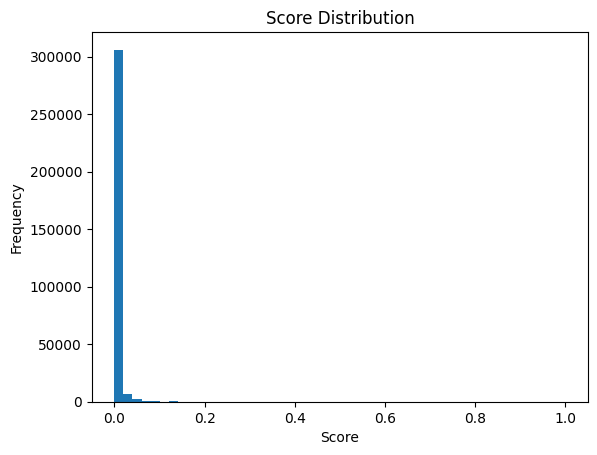


--- Evaluating Metric: cn ---
         u        v        cn   jaccard        aa      pa  label
0   270225   397620  0.034838  0.164042  0.016266  187680      1
1   173361  1167359  0.000557  0.500000  0.000628       8      1
2  1671776   931253  0.003344  0.089552  0.001804    4653      1
3   855218   836185  0.005574  0.055556  0.002811   36381      1
4   264626   295651  0.000000  0.000000  0.000000     108      1
AUC for cn: 0.8872725124925551
Precision: 1.0
Recall: 4.408726759711795e-05
Hits@1000: 0.0032


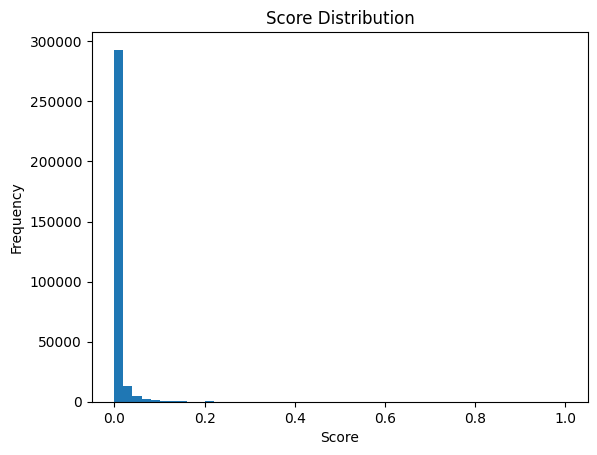


--- Evaluating Metric: jaccard ---
         u        v        cn   jaccard        aa      pa  label
0   270225   397620  0.034838  0.164042  0.016266  187680      1
1   173361  1167359  0.000557  0.500000  0.000628       8      1
2  1671776   931253  0.003344  0.089552  0.001804    4653      1
3   855218   836185  0.005574  0.055556  0.002811   36381      1
4   264626   295651  0.000000  0.000000  0.000000     108      1
AUC for jaccard: 0.8868790050729164
Precision: 1.0
Recall: 0.03598150854033355
Hits@1000: 0.0032


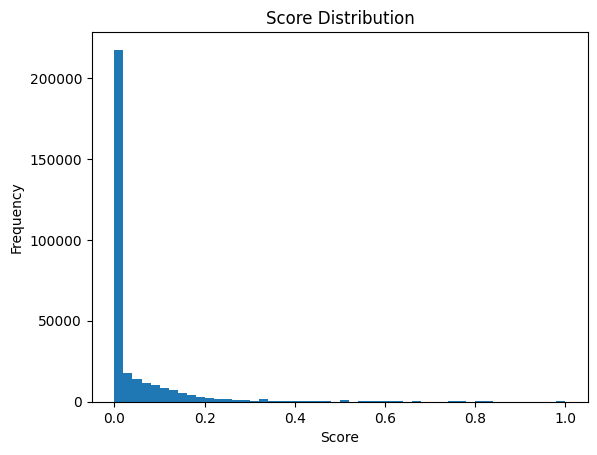


--- Evaluating Metric: pa ---
         u        v        cn   jaccard        aa            pa  label
0   270225   397620  0.034838  0.164042  0.016266  1.123056e-02      1
1   173361  1167359  0.000557  0.500000  0.000628  4.188745e-07      1
2  1671776   931253  0.003344  0.089552  0.001804  2.783720e-04      1
3   855218   836185  0.005574  0.055556  0.002811  2.176951e-03      1
4   264626   295651  0.000000  0.000000  0.000000  6.402796e-06      1
AUC for pa: 0.9362032831505653
Precision: 1.0
Recall: 0.0024122033556708824
Hits@1000: 0.0032


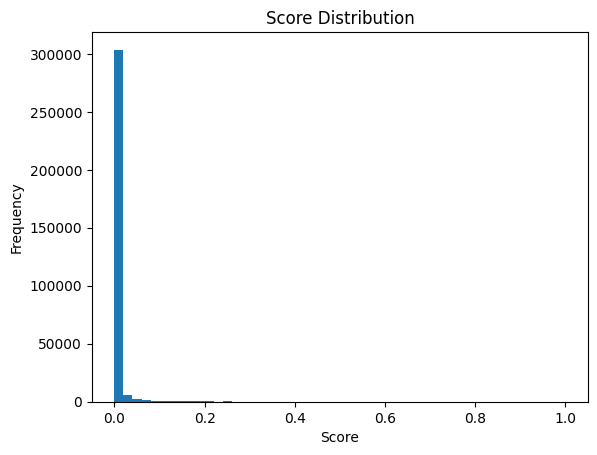


===== Evaluating Era 5 =====

--- Evaluating Metric: aa ---
         u        v  cn   jaccard        aa    pa  label
0  1041969   836185  15  0.064655  0.001466  8772      1
1  1643411   874186   1  0.017241  0.000118   814      1
2    44615   892616   0  0.000000  0.000000     4      1
3  2155036  2155038   7  0.777778  0.002140    64      1
4  6490867   687339   2  0.117647  0.000500    48      1
AUC for aa: 0.7525410254565216
Precision: 1.0
Recall: 5.1497548716681086e-05
Hits@1000: 0.0026


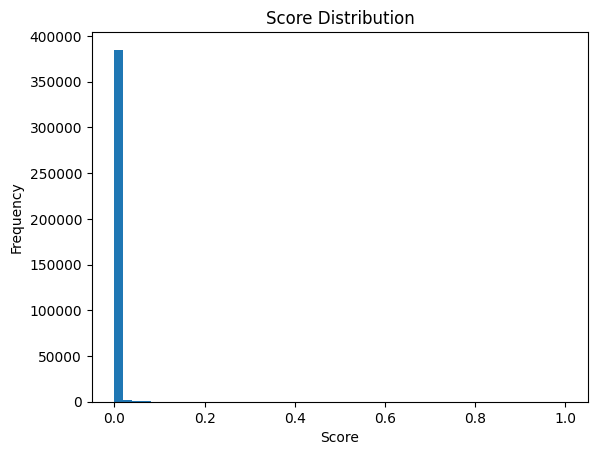


--- Evaluating Metric: cn ---
         u        v        cn   jaccard        aa    pa  label
0  1041969   836185  0.003234  0.064655  0.001466  8772      1
1  1643411   874186  0.000216  0.017241  0.000118   814      1
2    44615   892616  0.000000  0.000000  0.000000     4      1
3  2155036  2155038  0.001509  0.777778  0.002140    64      1
4  6490867   687339  0.000431  0.117647  0.000500    48      1
AUC for cn: 0.7528297119884948
Precision: 1.0
Recall: 5.1497548716681086e-05
Hits@1000: 0.0026


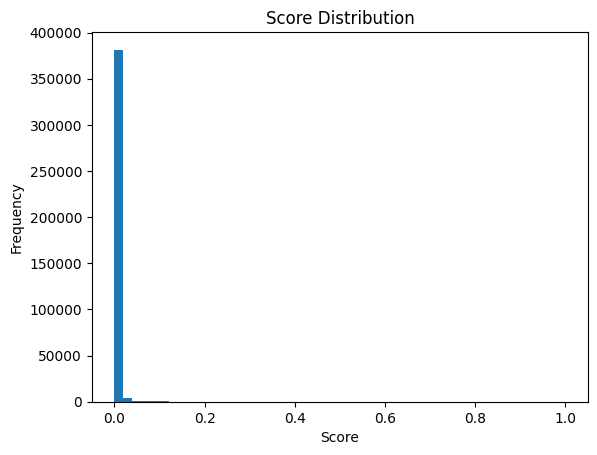


--- Evaluating Metric: jaccard ---
         u        v        cn   jaccard        aa    pa  label
0  1041969   836185  0.003234  0.064655  0.001466  8772      1
1  1643411   874186  0.000216  0.017241  0.000118   814      1
2    44615   892616  0.000000  0.000000  0.000000     4      1
3  2155036  2155038  0.001509  0.777778  0.002140    64      1
4  6490867   687339  0.000431  0.117647  0.000500    48      1
AUC for jaccard: 0.7527798867496366
Precision: 0.9995921696574225
Recall: 0.025244098380917068
Hits@1000: 0.0026


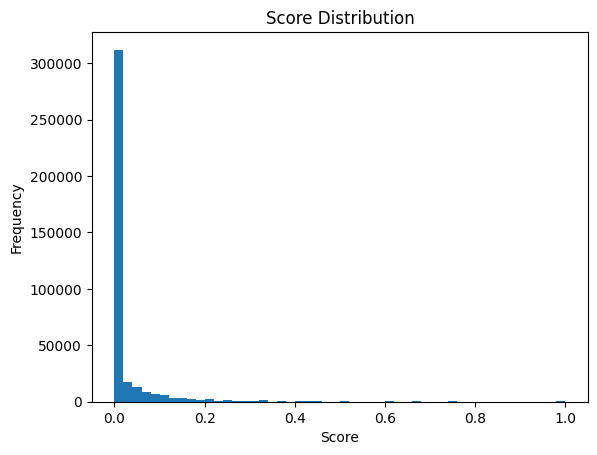


--- Evaluating Metric: pa ---
         u        v        cn   jaccard        aa            pa  label
0  1041969   836185  0.003234  0.064655  0.001466  3.895923e-04      1
1  1643411   874186  0.000216  0.017241  0.000118  3.611202e-05      1
2    44615   892616  0.000000  0.000000  0.000000  1.332547e-07      1
3  2155036  2155038  0.001509  0.777778  0.002140  2.798348e-06      1
4  6490867   687339  0.000431  0.117647  0.000500  2.087657e-06      1
AUC for pa: 0.8873747783601555
Precision: 1.0
Recall: 0.0008548593086969061
Hits@1000: 0.0026


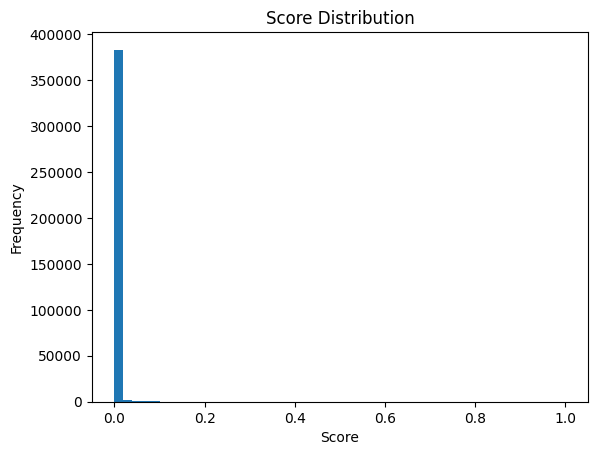

In [32]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt

# define a fuction to compute evaluation criteria for every era
def evaluate(df, graphMetric):
    # ----- AUC -----
    auc = roc_auc_score(df['label'], df[graphMetric])
    print(f"AUC for {graphMetric}: {auc}")

    # ----- Precision -----
    y_pred = [1 if s >= 0.5 else 0 for s in df[graphMetric]]
    precision = precision_score(df['label'], y_pred)
    print(f"Precision: {precision}")    

    # ----- Recall -----
    recall = recall_score(df['label'], y_pred)
    print(f"Recall: {recall}")  

    # ----- Hits@K -----
    K = 1000
    edges = list(zip(df['u'], df['v']))
    predicted_edges = pd.DataFrame({
        'edge': edges,
        'score': df[graphMetric]
    })

    # Sort by score descending
    predicted_edges_sorted = predicted_edges.sort_values('score', ascending=False)

    # Take top K edges
    top_k_edges = set(predicted_edges_sorted['edge'].iloc[:K])

    # Count how many true edges are in top K
    hits = sum(1 for edge in edges if edge in top_k_edges)

    # Compute Hits@K
    hits_at_k = hits / len(edges)
    print(f"Hits@{K}: {hits_at_k:.4f}")

    # ----- Score Distribution -----
    plt.hist(df[graphMetric], bins=50)
    plt.title("Score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.show()

    return

def normalizeCol(df, col):
    min_val = df[col].min()
    max_val = df[col].max()
    df[col] = (df[col] - min_val) / (max_val - min_val)
    return df


# ========== Calling Evaluation Function on all eras ==========
for var in range(1, 6):
    print(f"\n===== Evaluating Era {var} =====")
    df = pd.read_parquet(f'../outputs/link_prediction_outputs/Era{var}_scores.parquet')
    for col in ['aa', 'cn', 'jaccard', 'pa']:
        print(f"\n--- Evaluating Metric: {col} ---")
        normalizeCol(df, col)
        print(df.head())
        evaluate(df, graphMetric=col)  # You can change 'aa' to 'cn', 'jaccard', or 'pa' as needed

In [13]:
# get gephi downloads for all eras (different methods)

# era5_df = pd.read_parquet('../outputs/link_prediction_outputs/Era5_scores.parquet')

# cn_graph = nx.from_pandas_edgelist(era5_df, source = "u", target = "v", edge_attr = ["cn"])
# nx.write_gexf(cn_graph, "../gephi_data/raw_data/era5_cn.gexf")

# cn_graph = nx.from_pandas_edgelist(era5_df, source = "u", target = "v", edge_attr = ["jaccard"])
# nx.write_gexf(cn_graph, "../gephi_data/raw_data/era5_jaccard.gexf")

# cn_raph = nx.from_pandas_edgelist(era5_df, source = "u", target = "v", edge_attr = ["aa"])
# nx.write_gexf(cn_graph, "../gephi_data/raw_data/era5_aa.gexf")

# cn_graph = nx.from_pandas_edgelist(era5_df, source = "u", target = "v", edge_attr = ["pa"])
# nx.write_gexf(cn_graph, "../gephi_data/raw_data/era5_pa.gexf")
from pathlib import Path

eras = [1, 2, 3, 4, 5]
metrics = ["cn", "jaccard", "aa", "pa"]

for era in eras:
    # load parquet for this era
    df = pd.read_parquet(f"../outputs/link_prediction_outputs/Era{era}_scores.parquet")
    
    for metric in metrics:
        temp = df.rename(columns={metric: "weight"})
        # build graph with the specific metric
        G = nx.from_pandas_edgelist(
            temp,
            source="u",
            target="v",
            edge_attr=["weight"]
        )
        
        # output path
        out_path = Path(f"../gephi_data/raw_data/era{era}_{metric}.gexf")
        
        # write
        nx.write_gexf(G, out_path)


